In [1]:
# DEFINING REQUIRED PACKAGES ---------------------------------------
import matplotlib.pyplot as plt #import matplotlib to create plots
import scipy.optimize as opt; #allows for curve fitting
from scipy.odr import *
import pandas as pd #importing pandas to use dataframes
import numpy as np
from scipy.constants import g, pi
plt.style.reload_library()
plt.style.use(['science', 'grid'])
from scipy.odr import ODR, Model, Data, RealData
from scipy.optimize import curve_fit
import ipywidgets as widgets

In [2]:
# DEFINING FUNCTIONS USED FOR THIS LAB ---------------------------------------

# DEFINING A FUNCTION THAT RETURNS THE UNCERTAINTY USING VARIATIONAL METHOD
def uncertainty_var(values, deltas, function):
    values, deltas = np.array(values), np.array(deltas)
    delta_matrix = deltas*np.identity(values.shape[0])
    sum = 0
    for delta in delta_matrix:
        sum += (0.5*(abs(function(values + delta) - function(values)) + abs(function(values-delta) - function(values))))**2
    return np.sqrt(sum)

# DEFINING INTERSECTION FUNCTION THAT RECEIVES [m1,b1,m2,b2]
FindIntersection = lambda parameters : (parameters[3]-parameters[1])/(parameters[0]-parameters[2])

# FITTING FUNCTIONS
def linearODR(B,x):
    return B[0]*x + B[1]

def sigmoid(x, L ,x0, k, b):
    y = L / (1 + np.exp(-k*(x-x0)))+b
    return (y)
    
def LinearTangentFit(df,v_lim,function,color1,color2,x_label,y_label):
    
    fig = plt.figure(figsize=(5, 5), dpi=80)
    
    model = Model(function)
    
    df1 = df[df['$V_{Acc} \ (V)$'] <= v_lim]
    xdata1, ydata1, error_y1, error_x1 = df1[drop_down_x.value], df1[drop_down_y.value], df1[drop_down_error_y.value], df1[drop_down_error_x.value]
    data1 = RealData(xdata1, ydata1, error_x1, error_y1)
    odr1 = ODR(data1, model, [1,0])
    odr1.set_job(fit_type=2)
    output1 = odr1.run()
    a1,b1 = output1.beta[0], output1.beta[1]
    a1_error, b1_error = output1.sd_beta[0], output1.sd_beta[1]
    plt.errorbar(xdata1,ydata1,yerr=error_y1,capsize = 5,marker = 'o',markersize=4, linestyle = 'None',color='black')
    plt.errorbar(xdata1,ydata1,xerr=error_x1,capsize = 5,marker = 'o',markersize=4, linestyle = 'None',color='black')

    df2 = df[df['$V_{Acc} \ (V)$'] > v_lim]
    xdata2, ydata2, error_y2, error_x2 = df2[drop_down_x.value], df2[drop_down_y.value], df2[drop_down_error_y.value], df2[drop_down_error_x.value]
    data2 = RealData(xdata2, ydata2, error_x2, error_y2)
    odr2 = ODR(data2, model, [1,0])
    odr2.set_job(fit_type=2)
    output2 = odr2.run()
    a2,b2 = output2.beta[0], output2.beta[1]
    a2_error, b2_error = output2.sd_beta[0], output2.sd_beta[1]
    plt.errorbar(xdata2,ydata2,yerr=error_y2,capsize = 5,marker = 'o',markersize=4, linestyle = 'None',color='black')
    plt.errorbar(xdata2,ydata2,xerr=error_x2,capsize = 5,marker = 'o',markersize=4, linestyle = 'None',color='black')
    
    title = r'$\textbf{' + drop_down_y.value + ' vs ' + drop_down_x.value + '}$'
    label1 = r'$\textit{Y = ' + str("{:.2e}".format(a1)) + 'X + ' + str("{:.2e}".format(b1)) + '}$'
    label2 = r'$\textit{Y = ' + str("{:.2e}".format(a2)) + 'X + ' + str("{:.2e}".format(b2)) + '}$'
    
    # VERTICAL LINE
    plt.axvline(x=v_lim, color='k', linestyle='--')
    
    plt.plot(xdata1,function(output1.beta, xdata1),label = label1, color=color1, linewidth=1.5)
    plt.plot(xdata2,function(output2.beta, xdata2),label = label2, color=color2, linewidth=1.5)
    plt.legend(loc = 'upper left')
    plt.xlabel(r'$\textit{'+ x_label +'}$', fontsize = 16)
    plt.ylabel(r'$\textit{'+ y_label +'}$', fontsize = 16)
    plt.ticklabel_format(axis="y", style="sci", scilimits=(0,0))
    plt.title(title, fontsize = 18)
    plt.legend(prop={'size': 12}, loc=2)
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15)
    plt.savefig("Figures/figure.png")
    
    return a1, a1_error, b1, b1_error, a2, a2_error, b2, b2_error

def DerivativeFinder(df,color,x_label,y_label,low_limit, up_limit):
    
    fig = plt.figure(figsize=(5, 5), dpi=80)
        
    # USING THE DATA NEAR THE STOPPING VOLTAGE
    df = df[(df['$V_{Acc} \ (V)$'] > low_limit) & (df['$V_{Acc} \ (V)$'] < up_limit)]
        
    # FIRST DERIVATIVE
    xdata1, ydata1, error_y1, error_x1 = df[drop_down_x.value], np.gradient(df[drop_down_y.value].to_numpy()), 0, df[drop_down_error_x.value]
    plt.errorbar(xdata1,ydata1,xerr=error_x1,capsize = 5,marker = 'o',markersize=4, linestyle = 'None',color=color)
    plt.plot(xdata1,ydata1, 'o', color='red', linewidth=1.5, label='First Derivative')
        
    # SECOND DERIVATIVE
    xdata2, ydata2, error_y2, error_x2 = df[drop_down_x.value], np.gradient(np.gradient(df[drop_down_y.value])), df[drop_down_error_y.value], df[drop_down_error_x.value]
    plt.errorbar(xdata2,ydata2,xerr=error_x2,capsize = 5,marker = 'o',markersize=4, linestyle = 'None',color=color)
    plt.plot(xdata2,ydata2, 'o', color='blue', linewidth=1.5, label='Second Derivative')

    title = r'$\textbf{Derivative vs ' + drop_down_x.value + '}$'
   
    plt.legend(loc = 'upper left')
    plt.xlabel(r'$\textit{'+ x_label +'}$', fontsize = 16)
    plt.ylabel(r'$\textit{'+ y_label +'}$', fontsize = 16)
    plt.ticklabel_format(axis="y", style="sci", scilimits=(0,0))
    plt.title(title, fontsize = 18)
    plt.legend(prop={'size': 12}, loc=2)
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15)
    plt.savefig("Figures/figure.png")
    
    v_lim = xdata2.to_numpy()[np.where(ydata2 == ydata2.max())[0][0]]
    
    # VERTICAL LINE
    plt.axvline(x=v_lim, color='k', linestyle='--')
    
    return v_lim

def SigmoidFit(df,color,x_label,y_label,low_limit, up_limit, freq):
    
    fig = plt.figure(figsize=(5, 5), dpi=80)
        
    # USING THE DATA NEAR THE STOPPING VOLTAGE
    df = df[(df['$V_{Acc} \ (V)$'] > low_limit) & (df['$V_{Acc} \ (V)$'] < up_limit)]
        
    # DERIVATIVE
    xdata, ydata, error_y, error_x = df[drop_down_x.value], np.gradient(df[drop_down_y.value]), df[drop_down_error_y.value], df[drop_down_error_x.value]
    plt.errorbar(xdata,ydata,xerr=error_x,capsize = 5,marker = 'o',markersize=4, linestyle = 'None',color='black')
    plt.plot(xdata,ydata, 'o', color='black', linewidth=2)

    title = r'$\textbf{' + y_label + ' vs ' + x_label + '}$'
    
    p0 = [ydata.max(), np.median(xdata),1,ydata.min()] # this is an mandatory initial guess
    popt, pcov = curve_fit(sigmoid, xdata, ydata,p0, method='dogbox') # popt: L ,x0, k, b
    perr = np.sqrt(np.diag(pcov))
    
    # Plotting Sigmoid
    x = np.linspace(low_limit, up_limit, 100)
    y = sigmoid(x, *popt)
    plt.plot(x,y, color=color, label='Sigmoid Fit')

    plt.legend(loc = 'upper left')
    plt.xlabel(r'$\textit{'+ x_label +'}$', fontsize = 16)
    plt.ylabel(r'$\textit{'+ y_label +'}$', fontsize = 16)
    plt.ticklabel_format(axis="y", style="sci", scilimits=(0,0))
    plt.title(title, fontsize = 18)
    plt.xticks(np.arange(min(x), max(x)+.5, freq))
    plt.legend(prop={'size': 12}, loc=2)
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15)
    plt.savefig("Figures/figure.png")
    
    v_lim, err = popt[1], perr[1]
    
    # VERTICAL LINE
    plt.axvline(x=v_lim, color='k', linestyle='--')
    
    return v_lim, err

def LinearPlotODR(xdata,ydata,error_y,error_x,a,b,function,output,color,x_label,y_label):
    fig = plt.figure(figsize=(5, 5), dpi=80)
    plt.errorbar(xdata,ydata,yerr=error_y,capsize = 5,marker = 'o',markersize=4, linestyle = 'None',color='black')
    plt.errorbar(xdata,ydata,xerr=error_x,capsize = 5,marker = 'o',markersize=4, linestyle = 'None',color='black')
    if b==0:
        label = r'$\textit{Y = ' + str("{:.2e}".format(a)) + 'X}$'
    else:
        label = r'$\textit{Y = ' + str("{:.2e}".format(a)) + 'X + ' + str("{:.2e}".format(b)) + '}$'
    title = r'$\textbf{' + y_label + ' vs ' + x_label + '}$'
    plt.plot(xdata,function(output.beta, xdata),label = label, color=color)
    plt.legend(loc = 'upper left')
    plt.xlabel(r'$\textit{'+ x_label +'}$', fontsize = 16)
    plt.ylabel(r'$\textit{'+ y_label +'}$', fontsize = 16)
    plt.ticklabel_format(axis="y", style="sci", scilimits=(0,0))
    plt.legend(prop={'size': 12}, loc=2)
    plt.title(title, fontsize = 18)
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15)
    plt.savefig("Figures/figure.png")

## BLUE WAVELENGTH

In [3]:
# READING THE DATA FROM GOOGLE SHEETS ---------------------------------------
googleSheetId = '17H9-jFJKk_K1OKo1Tb_DOF_XxemwUpaan1Le9xGHFqA'
workSheetName = 'Blue_Obs'
URL = 'https://docs.google.com/spreadsheets/d/{0}/gviz/tq?tqx=out:csv&sheet={1}'.format(
    googleSheetId, workSheetName)
df = pd.read_csv(URL)
df = df.iloc[: , :4]
df = df.sort_values(by='$V_{Acc} \ (V)$', ascending=True)
df

,$V_{Acc} \ (V)$,V-Error (V),$I_{Photo} \ (nA)$,I-Error (nA)
32,-4.0,0.01,0.101,0.001
31,-3.5,0.01,0.104,0.001
30,-3.0,0.01,0.108,0.001
29,-2.5,0.01,0.111,0.001
28,-2.0,0.01,0.115,0.001
27,-1.9,0.01,0.101,0.001
26,-1.8,0.01,0.101,0.001
25,-1.7,0.01,0.102,0.001
24,-1.6,0.01,0.103,0.001
23,-1.5,0.01,0.120,0.001


In [4]:
# DISPLAYING DROPDOWN MENU OF COLUMNS ---------------------------------------
filenames = list(df.columns.values)
filenames.insert(0, 'Select Column')
drop_down_x = widgets.Dropdown(options=filenames,
                                description='X-axis',
                                disabled=False,
                                layout={'width': 'max-content'})
drop_down_y = widgets.Dropdown(options=filenames,
                                description='Y-axis',
                                disabled=False,
                                layout={'width': 'max-content'})
drop_down_error_y = widgets.Dropdown(options=filenames,
                                description='Error_Y',
                                disabled=False,
                                layout={'width': 'max-content'})
drop_down_error_x = widgets.Dropdown(options=filenames,
                                description='Error_X',
                                disabled=False,
                                layout={'width': 'max-content'})
display(drop_down_y, drop_down_x, drop_down_error_y, drop_down_error_x)

Dropdown(description='Y-axis', layout=Layout(width='max-content'), options=('Select Column', '$V_{Acc} \\ (V)$…

Dropdown(description='X-axis', layout=Layout(width='max-content'), options=('Select Column', '$V_{Acc} \\ (V)$…

Dropdown(description='Error_Y', layout=Layout(width='max-content'), options=('Select Column', '$V_{Acc} \\ (V)…

Dropdown(description='Error_X', layout=Layout(width='max-content'), options=('Select Column', '$V_{Acc} \\ (V)…

The stopping potential is: ( -0.9205948009961086  ±  0.025922117761056424 ) V


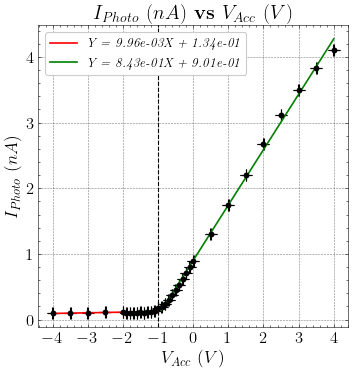

In [201]:
# PLOTTING AND CALCULATING THE STOPPING POTENTIAL
# TANGENTS  METHOD -----------
V_hand = -1
m1, m1_error, b1, b1_error, m2, m2_error, b2, b2_error = LinearTangentFit(df,V_hand,linearODR,'red','green',drop_down_x.value,drop_down_y.value)
# CALCULATING THE INTERSECTION
values, deltas = [m1,b1,m2,b2], [m1_error,b1_error,m2_error,b2_error]
V_stop = FindIntersection(values)
V_uncertainty = uncertainty_var(values, deltas, FindIntersection)
print("The stopping potential is: (", V_stop, " ± ", V_uncertainty, ") V")

The stopping potential is: ( -0.8 ) V


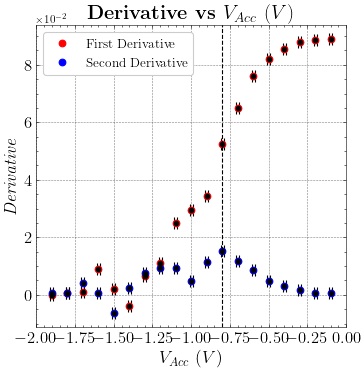

In [216]:
# DERIVATIVES METHOD ------
V_stop = DerivativeFinder(df,'black',drop_down_x.value,'Derivative',-2,0)
print("The stopping potential is: (", V_stop, ") V")

The stopping potential is: ( -0.8544594333404253  ±  0.020165408465973048 ) V


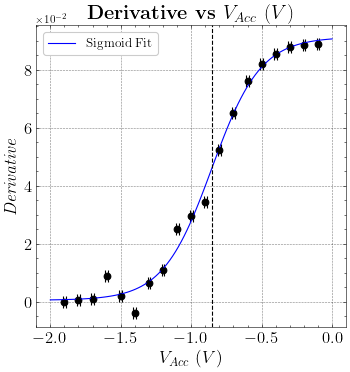

In [219]:
# SIGMOID FIT
V_stop, V_uncertainty = SigmoidFit(df,'Blue',drop_down_x.value,'Derivative',-2, 0, .5)
print("The stopping potential is: (", V_stop, " ± ", V_uncertainty, ") V")

## YELLOW WAVELENGTH

In [220]:
# READING THE DATA FROM GOOGLE SHEETS ---------------------------------------
googleSheetId = '17H9-jFJKk_K1OKo1Tb_DOF_XxemwUpaan1Le9xGHFqA'
workSheetName = 'Yellow_Obs'
URL = 'https://docs.google.com/spreadsheets/d/{0}/gviz/tq?tqx=out:csv&sheet={1}'.format(
    googleSheetId, workSheetName)
df = pd.read_csv(URL)
df = df.iloc[: , :4]
df = df.sort_values(by='$V_{Acc} \ (V)$', ascending=True)
df

,$V_{Acc} \ (V)$,V-Error (V),$I_{Photo} \ (nA)$,I-Error (nA)
32,-4.0,0.01,0.111,0.001
31,-3.5,0.01,0.114,0.001
30,-3.0,0.01,0.118,0.001
29,-2.5,0.01,0.121,0.001
28,-2.0,0.01,0.126,0.001
27,-1.5,0.01,0.129,0.001
26,-1.4,0.01,0.122,0.001
25,-1.3,0.01,0.122,0.001
24,-1.2,0.01,0.123,0.001
23,-1.1,0.01,0.123,0.001


In [86]:
# DISPLAYING DROPDOWN MENU OF COLUMNS ---------------------------------------
filenames = list(df.columns.values)
filenames.insert(0, 'Select Column')
drop_down_x = widgets.Dropdown(options=filenames,
                                description='X-axis',
                                disabled=False,
                                layout={'width': 'max-content'})
drop_down_y = widgets.Dropdown(options=filenames,
                                description='Y-axis',
                                disabled=False,
                                layout={'width': 'max-content'})
drop_down_error_y = widgets.Dropdown(options=filenames,
                                description='Error_Y',
                                disabled=False,
                                layout={'width': 'max-content'})
drop_down_error_x = widgets.Dropdown(options=filenames,
                                description='Error_X',
                                disabled=False,
                                layout={'width': 'max-content'})
display(drop_down_y, drop_down_x, drop_down_error_y, drop_down_error_x)

Dropdown(description='Y-axis', layout=Layout(width='max-content'), options=('Select Column', '$V_{Acc} \\ (V)$…

Dropdown(description='X-axis', layout=Layout(width='max-content'), options=('Select Column', '$V_{Acc} \\ (V)$…

Dropdown(description='Error_Y', layout=Layout(width='max-content'), options=('Select Column', '$V_{Acc} \\ (V)…

Dropdown(description='Error_X', layout=Layout(width='max-content'), options=('Select Column', '$V_{Acc} \\ (V)…

The stopping potential is: ( -0.37535353735798943  ±  0.025057351571047794 ) V


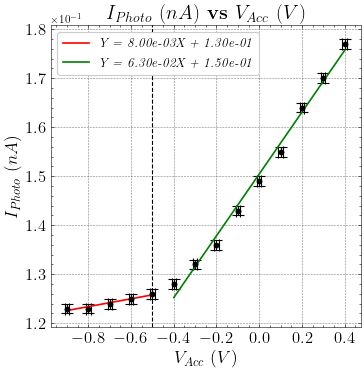

In [221]:
# PLOTTING AND CALCULATING THE STOPPING POTENTIAL
# TANGENTS  METHOD -----------
V_hand = -0.5
df1 = df[(df['$V_{Acc} \ (V)$'] > -1) & (df['$V_{Acc} \ (V)$'] < 0.5)]
m1, m1_error, b1, b1_error, m2, m2_error, b2, b2_error = LinearTangentFit(df1,V_hand,linearODR,'red','green',drop_down_x.value,drop_down_y.value)
# CALCULATING THE INTERSECTION
values, deltas = [m1,b1,m2,b2], [m1_error,b1_error,m2_error,b2_error]
V_stop = FindIntersection(values)
V_uncertainty = uncertainty_var(values, deltas, FindIntersection)
print("The stopping potential is: (", V_stop, " ± ", V_uncertainty, ") V")

The stopping potential is: ( -0.4 ) V


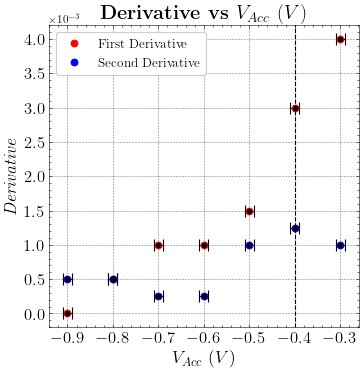

In [222]:
# DERIVATIVES METHOD ------
V_stop = DerivativeFinder(df1,'black',drop_down_x.value,'Derivative',-1.8,-0.2)
print("The stopping potential is: (", V_stop, ") V")

The stopping potential is: ( -0.3371679892123167  ±  0.02521543738378626 ) V


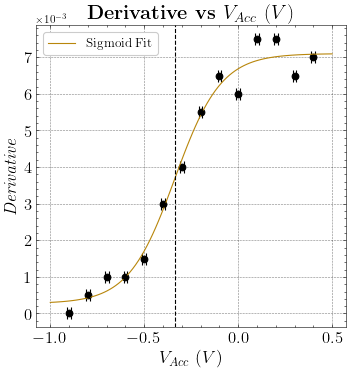

In [225]:
# SIGMOID FIT
V_stop, V_uncertainty = SigmoidFit(df,'darkgoldenrod',drop_down_x.value,'Derivative',-1, 0.5, .5)
print("The stopping potential is: (", V_stop, " ± ", V_uncertainty, ") V")

## GREEN WAVELENGTH

In [226]:
# READING THE DATA FROM GOOGLE SHEETS ---------------------------------------
googleSheetId = '17H9-jFJKk_K1OKo1Tb_DOF_XxemwUpaan1Le9xGHFqA'
workSheetName = 'Green_Obs'
URL = 'https://docs.google.com/spreadsheets/d/{0}/gviz/tq?tqx=out:csv&sheet={1}'.format(
    googleSheetId, workSheetName)
df = pd.read_csv(URL)
df = df.iloc[: , :4]
df = df.sort_values(by='$V_{Acc} \ (V)$', ascending=True)
df

,$V_{Acc} \ (V)$,V-Error (V),$I_{Photo} \ (nA)$,I-Error (nA)
32,-4.0,0.01,0.110,0.001
31,-3.5,0.01,0.113,0.001
30,-3.0,0.01,0.116,0.001
29,-2.5,0.01,0.119,0.001
28,-2.0,0.01,0.122,0.001
27,-1.5,0.01,0.126,0.001
26,-1.4,0.01,0.121,0.001
25,-1.3,0.01,0.121,0.001
24,-1.2,0.01,0.121,0.001
23,-1.1,0.01,0.121,0.001


The stopping potential is: ( -0.46198331254682196  ±  0.02306808081370733 ) V


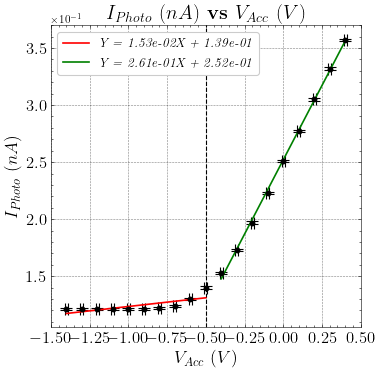

In [231]:
# PLOTTING AND CALCULATING THE STOPPING POTENTIAL
# TANGENTS  METHOD -----------
V_hand = -0.5
df1 = df[(df['$V_{Acc} \ (V)$'] > -1.5) & (df['$V_{Acc} \ (V)$'] < 0.5)]
m1, m1_error, b1, b1_error, m2, m2_error, b2, b2_error = LinearTangentFit(df1,V_hand,linearODR,'red','green',drop_down_x.value,drop_down_y.value)
# CALCULATING THE INTERSECTION
values, deltas = [m1,b1,m2,b2], [m1_error,b1_error,m2_error,b2_error]
V_stop = FindIntersection(values)
V_uncertainty = uncertainty_var(values, deltas, FindIntersection)
print("The stopping potential is: (", V_stop, " ± ", V_uncertainty, ") V")

The stopping potential is: ( -0.4 ) V


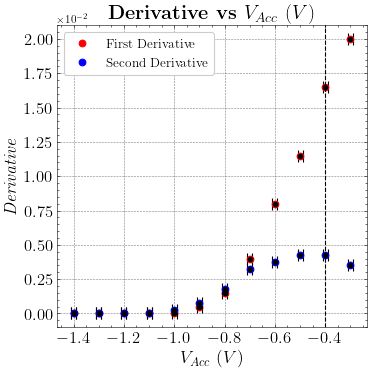

In [228]:
# DERIVATIVES METHOD ------
V_stop = DerivativeFinder(df1,'black',drop_down_x.value,'Derivative',-1.8,-0.2)
print("The stopping potential is: (", V_stop, ") V")

The stopping potential is: ( -0.4751883644123527  ±  0.010230836406846713 ) V


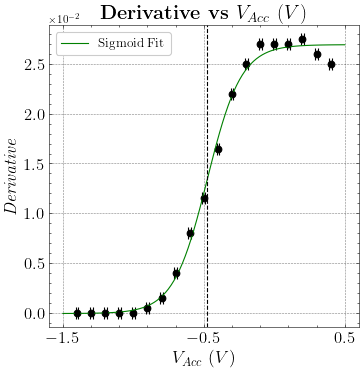

In [235]:
# SIGMOID FIT
V_stop, V_uncertainty = SigmoidFit(df,'Green',drop_down_x.value,'Derivative',-1.5, 0.5, 1)
print("The stopping potential is: (", V_stop, " ± ", V_uncertainty, ") V")

## UV 3117 WAVELENGTH

In [250]:
# READING THE DATA FROM GOOGLE SHEETS ---------------------------------------
googleSheetId = '17H9-jFJKk_K1OKo1Tb_DOF_XxemwUpaan1Le9xGHFqA'
workSheetName = 'UV1_Obs'
URL = 'https://docs.google.com/spreadsheets/d/{0}/gviz/tq?tqx=out:csv&sheet={1}'.format(
    googleSheetId, workSheetName)
df = pd.read_csv(URL)
df = df.iloc[: , :4]
df = df.sort_values(by='$V_{Acc} \ (V)$', ascending=True)
df

,$V_{Acc} \ (V)$,V-Error (V),$I_{Photo} \ (nA)$,I-Error (nA)
30,-4.0,0.01,0.0934,0.001
29,-3.8,0.01,0.0944,0.001
28,-3.6,0.01,0.0945,0.001
27,-3.4,0.01,0.0955,0.001
26,-3.2,0.01,0.0950,0.001
25,-3.0,0.01,0.0962,0.001
24,-2.8,0.01,0.0979,0.001
23,-2.6,0.01,0.0997,0.001
22,-2.4,0.01,0.1020,0.001
21,-2.2,0.01,0.1050,0.001


The stopping potential is: ( -2.036844550730839  ±  0.07238665907111874 ) V


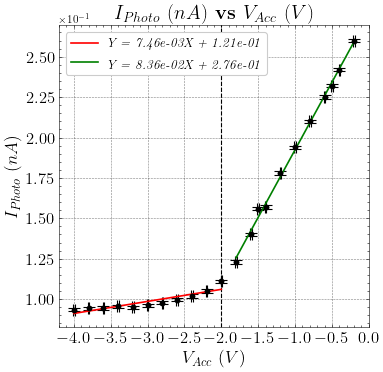

In [251]:
# PLOTTING AND CALCULATING THE STOPPING POTENTIAL
# TANGENTS  METHOD -----------
V_hand = -2
df1 = df[(df['$V_{Acc} \ (V)$'] < 0)]
m1, m1_error, b1, b1_error, m2, m2_error, b2, b2_error = LinearTangentFit(df1,V_hand,linearODR,'red','green',drop_down_x.value,drop_down_y.value)
# CALCULATING THE INTERSECTION
values, deltas = [m1,b1,m2,b2], [m1_error,b1_error,m2_error,b2_error]
V_stop = FindIntersection(values)
V_uncertainty = uncertainty_var(values, deltas, FindIntersection)
print("The stopping potential is: (", V_stop, " ± ", V_uncertainty, ") V")

The stopping potential is: ( -2.0 ) V


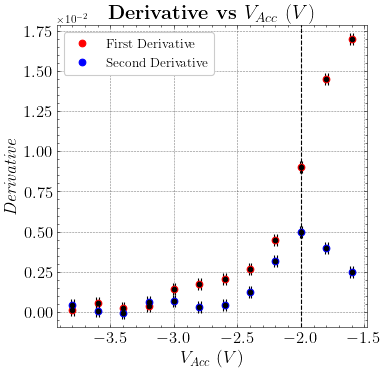

In [253]:
# DERIVATIVES METHOD ------
V_stop = DerivativeFinder(df1,'black',drop_down_x.value,'Derivative',-4,-1.5)
print("The stopping potential is: (", V_stop, ") V")

The stopping potential is: ( -1.9692258217906486  ±  0.0058202626630009 ) V


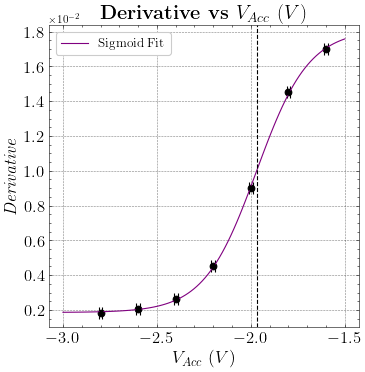

In [255]:
# SIGMOID FIT
V_stop, V_uncertainty = SigmoidFit(df,'Purple',drop_down_x.value,'Derivative',-3, -1.5, 0.5)
print("The stopping potential is: (", V_stop, " ± ", V_uncertainty, ") V")

## UV 3655 WAVELENGTH

In [5]:
# READING THE DATA FROM GOOGLE SHEETS ---------------------------------------
googleSheetId = '17H9-jFJKk_K1OKo1Tb_DOF_XxemwUpaan1Le9xGHFqA'
workSheetName = 'UV2_Obs'
URL = 'https://docs.google.com/spreadsheets/d/{0}/gviz/tq?tqx=out:csv&sheet={1}'.format(
    googleSheetId, workSheetName)
df = pd.read_csv(URL)
df = df.iloc[: , :4]
df = df.sort_values(by='$V_{Acc} \ (V)$', ascending=True)
df

,$V_{Acc} \ (V)$,V-Error (V),$I_{Photo} \ (nA)$,I-Error (nA)
32,-4.0,0.01,-0.0326,0.001
31,-3.5,0.01,-0.0314,0.001
30,-3.0,0.01,-0.0300,0.001
29,-2.5,0.01,-0.0281,0.001
28,-2.4,0.01,-0.0296,0.001
27,-2.3,0.01,-0.0279,0.001
26,-2.2,0.01,-0.0252,0.001
25,-2.1,0.01,-0.0211,0.001
24,-2.0,0.01,-0.0153,0.001
23,-1.9,0.01,-0.0070,0.001


The stopping potential is: ( -1.2754266059956443  ±  0.043138589172259434 ) V


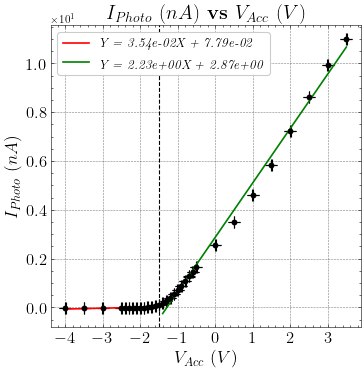

In [8]:
# PLOTTING AND CALCULATING THE STOPPING POTENTIAL
# TANGENTS  METHOD -----------
V_hand = -1.5
df1 = df[(df['$V_{Acc} \ (V)$'] < 4)]
m1, m1_error, b1, b1_error, m2, m2_error, b2, b2_error = LinearTangentFit(df1,V_hand,linearODR,'red','green',drop_down_x.value,drop_down_y.value)
# CALCULATING THE INTERSECTION
values, deltas = [m1,b1,m2,b2], [m1_error,b1_error,m2_error,b2_error]
V_stop = FindIntersection(values)
V_uncertainty = uncertainty_var(values, deltas, FindIntersection)
print("The stopping potential is: (", V_stop, " ± ", V_uncertainty, ") V")

The stopping potential is: ( -0.5 ) V


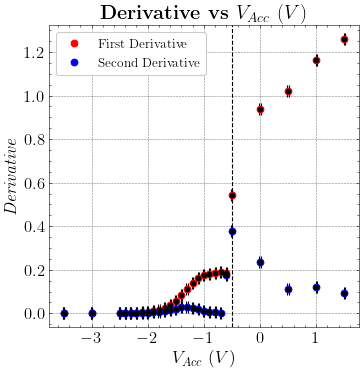

In [163]:
# DERIVATIVES METHOD ------
V_stop = DerivativeFinder(df1,'black',drop_down_x.value,'Derivative',-4,2)
print("The stopping potential is: (", V_stop, ") V")

The stopping potential is: ( -1.3540411229114924  ±  0.004430409601038393 ) V


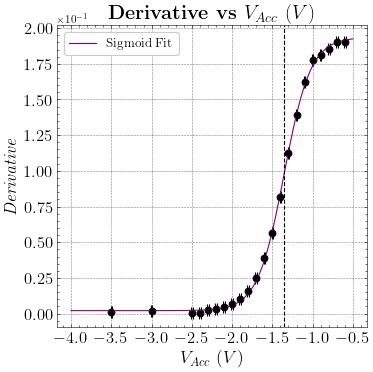

In [13]:
# SIGMOID FIT
V_stop, V_uncertainty = SigmoidFit(df,'Purple',drop_down_x.value,'Derivative',-4, -0.5, .5)
print("The stopping potential is: (", V_stop, " ± ", V_uncertainty, ") V")

## VIOLET (NO FILTER) WAVELENGTH

In [14]:
# READING THE DATA FROM GOOGLE SHEETS ---------------------------------------
googleSheetId = '17H9-jFJKk_K1OKo1Tb_DOF_XxemwUpaan1Le9xGHFqA'
workSheetName = 'Violet1'
URL = 'https://docs.google.com/spreadsheets/d/{0}/gviz/tq?tqx=out:csv&sheet={1}'.format(
    googleSheetId, workSheetName)
df = pd.read_csv(URL)
df = df.iloc[: , :4]
df = df.sort_values(by='$V_{Acc} \ (V)$', ascending=True)
df

,$V_{Acc} \ (V)$,V-Error (V),$I_{Photo} \ (nA)$,I-Error (nA)
32,-4.0,0.01,-0.0187,0.001
31,-3.5,0.01,-0.0183,0.001
30,-3.0,0.01,-0.0178,0.001
29,-2.5,0.01,-0.0171,0.001
28,-2.0,0.01,-0.0141,0.001
27,-1.9,0.01,-0.0138,0.001
26,-1.8,0.01,-0.0130,0.001
25,-1.7,0.01,-0.0117,0.001
24,-1.6,0.01,-0.0095,0.001
23,-1.5,0.01,-0.0057,0.001


The stopping potential is: ( -0.9088076163019224  ±  0.02943922870396945 ) V


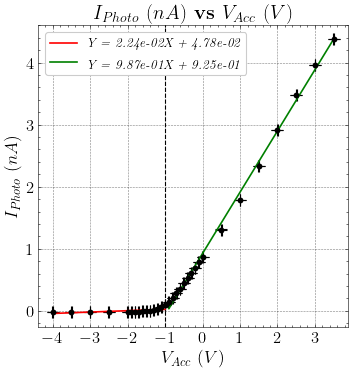

In [17]:
# PLOTTING AND CALCULATING THE STOPPING POTENTIAL
# TANGENTS  METHOD -----------
V_hand = -1
df1 = df[(df['$V_{Acc} \ (V)$'] < 4)]
m1, m1_error, b1, b1_error, m2, m2_error, b2, b2_error = LinearTangentFit(df1,V_hand,linearODR,'red','green',drop_down_x.value,drop_down_y.value)
# CALCULATING THE INTERSECTION
values, deltas = [m1,b1,m2,b2], [m1_error,b1_error,m2_error,b2_error]
V_stop = FindIntersection(values)
V_uncertainty = uncertainty_var(values, deltas, FindIntersection)
print("The stopping potential is: (", V_stop, " ± ", V_uncertainty, ") V")

The stopping potential is: ( -1.0100682546555773  ±  0.0037932603267310456 ) V


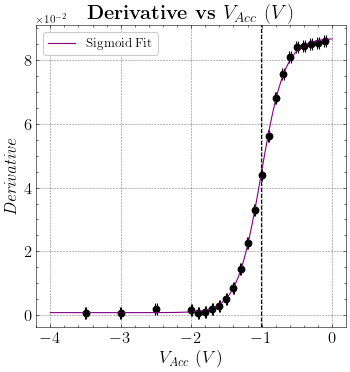

In [20]:
# SIGMOID FIT
V_stop, V_uncertainty = SigmoidFit(df,'Purple',drop_down_x.value,'Derivative',-4, 0, 1)
print("The stopping potential is: (", V_stop, " ± ", V_uncertainty, ") V")

## VIOLET (0.5 FILTER) WAVELENGTH

In [38]:
# READING THE DATA FROM GOOGLE SHEETS ---------------------------------------
googleSheetId = '17H9-jFJKk_K1OKo1Tb_DOF_XxemwUpaan1Le9xGHFqA'
workSheetName = 'Violet2'
URL = 'https://docs.google.com/spreadsheets/d/{0}/gviz/tq?tqx=out:csv&sheet={1}'.format(
    googleSheetId, workSheetName)
df = pd.read_csv(URL)
df = df.iloc[: , :4]
df = df.sort_values(by='$V_{Acc} \ (V)$', ascending=True)
df

,$V_{Acc} \ (V)$,V-Error (V),$I_{Photo} \ (nA)$,I-Error (nA)
32,-4.0,0.01,-0.00600,0.001
31,-3.5,0.01,-0.00550,0.001
30,-3.0,0.01,-0.00480,0.001
29,-2.5,0.01,-0.00460,0.001
28,-2.0,0.01,-0.00410,0.001
27,-1.9,0.01,-0.00400,0.001
26,-1.8,0.01,-0.00380,0.001
25,-1.7,0.01,-0.00320,0.001
24,-1.6,0.01,-0.00240,0.001
23,-1.5,0.01,-0.00090,0.001


The stopping potential is: ( -0.9166833565542509  ±  0.028801133287399115 ) V


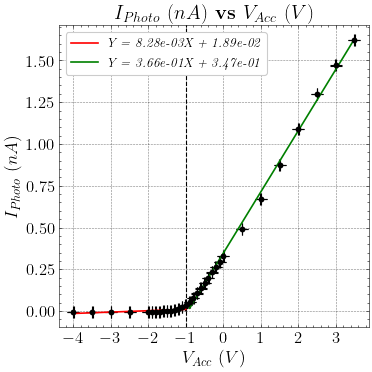

In [27]:
# PLOTTING AND CALCULATING THE STOPPING POTENTIAL
# TANGENTS  METHOD -----------
V_hand = -1
df1 = df[(df['$V_{Acc} \ (V)$'] < 4)]
m1, m1_error, b1, b1_error, m2, m2_error, b2, b2_error = LinearTangentFit(df1,V_hand,linearODR,'red','green',drop_down_x.value,drop_down_y.value)
# CALCULATING THE INTERSECTION
values, deltas = [m1,b1,m2,b2], [m1_error,b1_error,m2_error,b2_error]
V_stop = FindIntersection(values)
V_uncertainty = uncertainty_var(values, deltas, FindIntersection)
print("The stopping potential is: (", V_stop, " ± ", V_uncertainty, ") V")

The stopping potential is: ( -1.0086379574570155  ±  0.003912353323896647 ) V


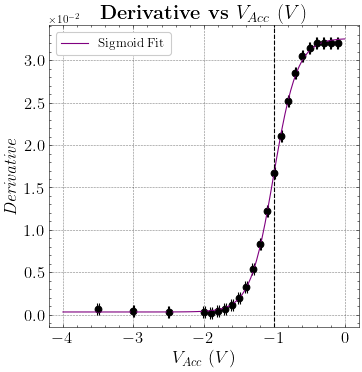

In [39]:
# SIGMOID FIT
V_stop, V_uncertainty = SigmoidFit(df,'Purple',drop_down_x.value,'Derivative',-4, 0, 1)
print("The stopping potential is: (", V_stop, " ± ", V_uncertainty, ") V")

## VIOLET (1 FILTER) WAVELENGTH

In [30]:
# READING THE DATA FROM GOOGLE SHEETS ---------------------------------------
googleSheetId = '17H9-jFJKk_K1OKo1Tb_DOF_XxemwUpaan1Le9xGHFqA'
workSheetName = 'Violet3'
URL = 'https://docs.google.com/spreadsheets/d/{0}/gviz/tq?tqx=out:csv&sheet={1}'.format(
    googleSheetId, workSheetName)
df = pd.read_csv(URL)
df = df.iloc[: , :4]
df = df.sort_values(by='$V_{Acc} \ (V)$', ascending=True)
df

,$V_{Acc} \ (V)$,V-Error (V),$I_{Photo} \ (nA)$,I-Error (nA)
37,-4.0,0.01,-0.00140,0.001
36,-3.5,0.01,-0.00100,0.001
35,-3.0,0.01,-0.00060,0.001
34,-2.5,0.01,-0.00014,0.001
33,-2.0,0.01,0.00020,0.001
32,-2.0,0.01,0.00030,0.001
31,-1.9,0.01,0.00015,0.001
30,-1.8,0.01,0.00030,0.001
29,-1.7,0.01,0.00050,0.001
28,-1.6,0.01,0.00080,0.001


The stopping potential is: ( -0.9068082466676695  ±  0.028207585150575462 ) V


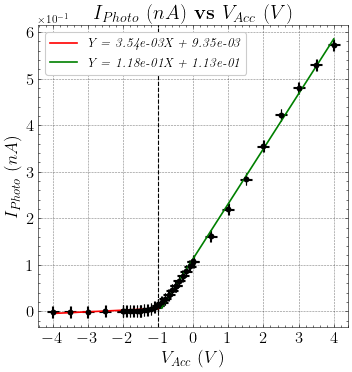

In [31]:
# PLOTTING AND CALCULATING THE STOPPING POTENTIAL
# TANGENTS  METHOD -----------
V_hand = -1
df1 = df[(df['$V_{Acc} \ (V)$'] < 4)]
m1, m1_error, b1, b1_error, m2, m2_error, b2, b2_error = LinearTangentFit(df1,V_hand,linearODR,'red','green',drop_down_x.value,drop_down_y.value)
# CALCULATING THE INTERSECTION
values, deltas = [m1,b1,m2,b2], [m1_error,b1_error,m2_error,b2_error]
V_stop = FindIntersection(values)
V_uncertainty = uncertainty_var(values, deltas, FindIntersection)
print("The stopping potential is: (", V_stop, " ± ", V_uncertainty, ") V")

The stopping potential is: ( -0.9483839370357926  ±  0.0707356473349871 ) V


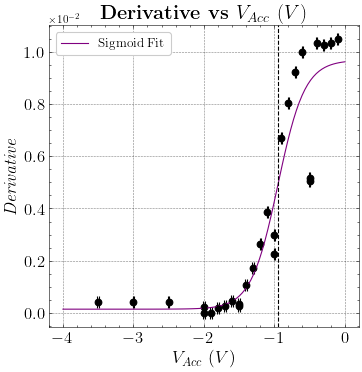

In [36]:
# SIGMOID FIT
V_stop, V_uncertainty = SigmoidFit(df,'Purple',drop_down_x.value,'Derivative',-4, 0, 1)
print("The stopping potential is: (", V_stop, " ± ", V_uncertainty, ") V")

## FINDING h/e

In [40]:
# READING THE DATA FROM GOOGLE SHEETS ---------------------------------------
googleSheetId = '17H9-jFJKk_K1OKo1Tb_DOF_XxemwUpaan1Le9xGHFqA'
workSheetName = 'Results'
URL = 'https://docs.google.com/spreadsheets/d/{0}/gviz/tq?tqx=out:csv&sheet={1}'.format(
    googleSheetId, workSheetName)
df = pd.read_csv(URL)
df

,$V_{Stop} (V)$,Error V,$\lambda \ (nm)$,$\nu \ (Hz)$,Error Freq
0,0.854459,0.020165,435.8,688389169343736,0
1,0.339858,0.019836,577.9,519120955182558,0
2,0.475963,0.010163,546.1,549349935909174,0
3,1.969226,0.005820,313.1,958160332162248,0
4,1.354041,0.004430,365.5,820793433652531,0
5,1.010068,0.003793,404.7,741289844329133,0


In [41]:
# DISPLAYING DROPDOWN MENU OF COLUMNS ---------------------------------------
filenames = list(df.columns.values)
filenames.insert(0, 'Select Column')
drop_down_x = widgets.Dropdown(options=filenames,
                                description='X-axis',
                                disabled=False,
                                layout={'width': 'max-content'})
drop_down_y = widgets.Dropdown(options=filenames,
                                description='Y-axis',
                                disabled=False,
                                layout={'width': 'max-content'})
drop_down_error_y = widgets.Dropdown(options=filenames,
                                description='Error_Y',
                                disabled=False,
                                layout={'width': 'max-content'})
drop_down_error_x = widgets.Dropdown(options=filenames,
                                description='Error_X',
                                disabled=False,
                                layout={'width': 'max-content'})
display(drop_down_y, drop_down_x, drop_down_error_y, drop_down_error_x)

Dropdown(description='Y-axis', layout=Layout(width='max-content'), options=('Select Column', '$V_{Stop} (V)$',…

Dropdown(description='X-axis', layout=Layout(width='max-content'), options=('Select Column', '$V_{Stop} (V)$',…

Dropdown(description='Error_Y', layout=Layout(width='max-content'), options=('Select Column', '$V_{Stop} (V)$'…

Dropdown(description='Error_X', layout=Layout(width='max-content'), options=('Select Column', '$V_{Stop} (V)$'…

/Users/rvizarreta/opt/anaconda3/lib/python3.8/site-packages/scipy/odr/odrpack.py:393: RuntimeWarning: divide by zero encountered in true_divide
  return 1./numpy.power(sd, 2)


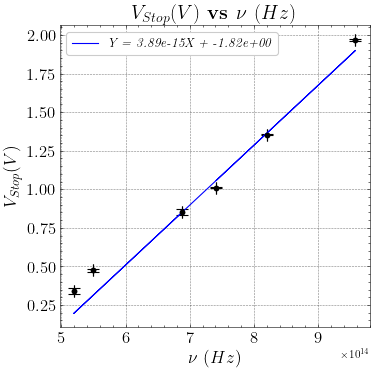

In [44]:
# FITTING THE DATA USING A LINEAR RELATIONSHIP WITH UNCERTAINTY IN Y ---------------------------------------
xdata, ydata, error_y, error_x = df[drop_down_x.value], df[drop_down_y.value], df[drop_down_error_y.value], df[drop_down_error_x.value]
model = Model(linearODR)

data = RealData(xdata, ydata, error_x, error_y)
odr = ODR(data, model, [1,10000])
odr.set_job(fit_type=2)
output = odr.run()
a,b = output.beta[0], output.beta[1]
print(odr)
#Calculate the error on the fits from the std matrix
slope = output.beta[0]
slope_error = output.sd_beta[0]

#plt.plot(xdata, linearPlot(output.beta, xdata))
LinearPlotODR(xdata, ydata, error_y, error_x, a,b, linearODR, output,'Blue',drop_down_x.value,drop_down_y.value)

In [43]:
from scipy.constants import h, e
ratio_theor = h/e
ratio_exp = slope
ratio_error = slope_error
units = 'V-s'

print('Theoretical h/e ratio: ' + "{:.4e}".format(ratio_theor) + ' ' + units)
print('Experimental h/e ratio: ' + "{:.4e}".format(ratio_exp) + ' ± ' + "{:.4e}".format(ratio_error) + ' ' + units)

# DETERMING THE %ERROR
error = abs((ratio_exp-ratio_theor)/ratio_theor)*100
print("Percentage error: ", error, "%")

Theoretical h/e ratio: 4.1357e-15 V-s
Experimental h/e ratio: 3.8858e-15 ± 2.9180e-16 V-s
Percentage error:  6.041695413012533 %


## INTENSITY DEPENDENCE

In [3]:
# READING THE DATA FROM GOOGLE SHEETS ---------------------------------------
googleSheetId = '17H9-jFJKk_K1OKo1Tb_DOF_XxemwUpaan1Le9xGHFqA'
workSheetName = 'Intensity'
URL = 'https://docs.google.com/spreadsheets/d/{0}/gviz/tq?tqx=out:csv&sheet={1}'.format(
    googleSheetId, workSheetName)
df = pd.read_csv(URL)
# NORMALIZING
df['I1'] = df['I1']/df['I1'].max()
df['I2'] = df['I2']/df['I2'].max()
df['I3'] = df['I3']/df['I3'].max()
df

,V1,I1,V2,I2,V3,I3
0,4.0,1.000000,4.0,1.000000,4.0,1.000000
1,3.5,0.926004,3.5,0.925714,3.5,0.924956
2,3.0,0.837209,3.0,0.840000,3.0,0.839442
3,2.5,0.735729,2.5,0.742857,2.5,0.736475
4,2.0,0.617336,2.0,0.622857,2.0,0.619546
5,1.5,0.492600,1.5,0.498857,1.5,0.495637
6,1.0,0.378436,1.0,0.383429,1.0,0.382199
7,0.5,0.276956,0.5,0.281143,0.5,0.280977
8,0.0,0.183932,0.0,0.187429,0.0,0.184991
9,-0.1,0.165539,-0.1,0.168571,0.0,0.186736


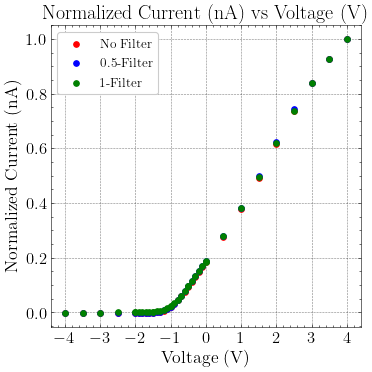

In [24]:
# PLOTTING
fig = plt.figure(figsize=(5, 5), dpi=80)

plt.scatter(df['V1'],df['I1'], color='red', label='No Filter', s=25)
plt.scatter(df['V2'],df['I2'], color='blue', label='0.5-Filter', s=25)
plt.scatter(df['V3'],df['I3'], color='green', label='1-Filter', s=25)
title = 'Normalized Current (nA) vs Voltage (V)'
   
plt.legend(loc = 'upper left')
plt.xlabel('Voltage (V)', fontsize = 16)
plt.ylabel('Normalized Current (nA)', fontsize = 16)
plt.ticklabel_format(axis="y", style="sci", scilimits=(0,0))
plt.title(title, fontsize = 18)
plt.legend(prop={'size': 12}, loc=2)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.savefig("Figures/figure.png")